# Neural Network

With neural networks we wish to map input vector, $X \in R^{m\times n}$ to output vector $y \in R^{m\times q}$, where $m$ is the number of training examples, $n$ is the number of input features and $q$ is the number of output features. This mapping can be thought of as a function approximation, where we learn the function, $y=f(X)$. A neural network has the potential to model arbitrarily complex functions through the use of non-linear activations. Without these, the network becomes linear in the parameters.

In the regression case, we minimise the L2 norm between ground truth labels $Y$ and predicted output $A^{[2]}$:

$J = \sum|| Y - A^{[2]} ||^2$

where $A^{[2]}=W^{[2]}Z^{[1]}$ is the output of the last layer of the neural network.

To be able to optimise the parameters, we need to compute the gradient of the cost function w.r.t. the parameters, $W$ and $b$, where we can compute the chain rule and "backprop" to the parameter of interest. Taking the weights of the last layer as an example:

$\frac{dJ}{dW} = (Y - A^{[2]}) \frac{dA^{[2]}}{dW} = (Y - A^{[2]}) Z^{[1]}$

The gradient computation can then be broken down into simple calculations, i.e:

$\frac{dJ}{dW} = \frac{dJ}{dA^{[1]}}\frac{dA^{[1]}}{dW}$

In this case, since the last layer is linear, this is the same derivitive as in linear regression.

If we had one hidden layer with a non-linear activation function $f()$ the forward pass might look something like this:

- Input $X$:
    - $A^{[1]} = W^{[1]} X + B^{[1]}$

    - $Z^{[1]} = f(A^{[1]})$

    - $A^{[2]} = W^{[2]} Z^{[1]} + B^{[2]}$
- Output $A^{[2]}$

Then as an example the gradient of $J$ w.r.t. $W^{[1]}$ using backprop is:

- $\frac{dJ}{W^{[1]}} = \frac{dJ}{dA^{[2]}}\frac{dA^{[2]}}{dZ^{[1]}}\frac{dZ^{[1]}}{dA^{[1]}}\frac{dA^{[1]}}{dW^{[1]}}$
- $\frac{dJ}{W^{[1]}} = (Y - A^{[2]})W^{[2]}f'(Z^{[1]})X$


# Generate dataset

In [1]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

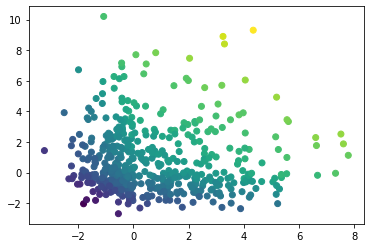

In [2]:
np.random.seed(13)
X, y = make_regression(n_samples=500, n_features=2, n_informative=2, n_targets=1, tail_strength=0.5, noise=10)
X[X>0] += 2*X[X>0]
plt.scatter(X[:,0], X[:,1], c=y)

# Model

In [3]:
def relu(z):
    return np.maximum(0,z)

def drelu(X):
    X[X>=0] = 1
    X[X<0] = 0
    return X
    
def tanh(z):
    return (np.exp(z)-np.exp(-z))/(np.exp(z) + np.exp(-z))

def dtanh(z):
    return 1 - tanh(z)**2
    
def mse(y, y_hat):
    return ((y-y_hat)**2).mean()

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def dsigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z)) 

In [4]:
class RegNet:
    def __init__(self, input_dim, output_dim=1, n_hidden=20, learning_rate=0.01, activation='relu'):
        # initialise params
        self.w1 = np.random.normal(0,0.01,size=(input_dim, n_hidden))
        self.b1 = np.zeros((n_hidden, 1))
        self.w2 = np.random.normal(0,0.01,size=(n_hidden, output_dim))
        self.b2 = np.zeros((output_dim,1))
        
        # set activation and lr
        self.alpha = learning_rate
        if activation == 'relu':
            self.activ = relu
            self.grad_activ = drelu
        elif activation == 'tanh':
            self.activ = tanh
            self.grad_activ = dtanh
    
    def forward(self, X):
        # forward pass of network
        self.z1 = self.w1.T @ X.T + self.b1
        self.a1 = self.activ(self.z1)
        self.z2 = 1/self.m * (self.w2.T @ self.a1) + self.b2
        
        return self.z2
    
    def backward(self, X, y):
        # backpropogate gradients
        assert len(y.shape) == 2
        self.dz2 = (self.z2 - y.T)
        self.dw2 = 1/self.m *(self.dz2 @ self.a1.T).T
        self.db2 = 1/self.m * np.sum(self.dz2, axis=1, keepdims=True)
        assert self.dw2.shape == self.w2.shape
        
        self.dz1 = (self.w2 @ self.dz2) * self.grad_activ(self.z1)
        self.db1 = 1/self.m * np.sum(self.dz1, axis=1, keepdims=True) #.reshape(n_hidden, 1)
        self.dw1 = 1/self.m * (self.dz1 @ X).T
        assert self.dw1.shape == self.w1.shape
    
    def step(self):
        # step optimiser
        self.w1 = self.w1 - self.alpha*self.dw1
        self.b1 = self.b1 - self.alpha*self.db1
        self.w2 = self.w2 - self.alpha*self.dw2
        self.b2 = self.b2 - self.alpha*self.db2
        
    def train(self, X, y):
        self.m = len(X)
        self.forward(X)
        self.backward(X,y)
    
    def predict(self, X):
        return self.forward(X)

In [5]:
np.random.seed(20)
model = RegNet(input_dim=X.shape[1], learning_rate=0.001, activation='relu')

In [6]:
n_epochs = 2000
for i in range(n_epochs):
    model.m = len(X)
    # Forward pass
    y_pred = model.predict(X)
    
    # loss
    loss = mse(y.reshape(-1,1), y_pred.T)
    
    # Compute gradients
    model.backward(X, y.reshape(-1,1))
    
    # Step optimizer
    model.step()
    
    if i % 100 == 0:
        print(f'Loss: {loss}, Epoch: {i}/{n_epochs}')

Loss: 15898.4527038268, Epoch: 0/2000
Loss: 7804.057120109969, Epoch: 100/2000
Loss: 877.8223847748682, Epoch: 200/2000
Loss: 471.44586936129565, Epoch: 300/2000
Loss: 295.39762230245793, Epoch: 400/2000
Loss: 197.59367730334827, Epoch: 500/2000
Loss: 154.983740615334, Epoch: 600/2000
Loss: 136.72233722732716, Epoch: 700/2000
Loss: 127.50404329197056, Epoch: 800/2000
Loss: 120.78160974462747, Epoch: 900/2000
Loss: 114.83773278281217, Epoch: 1000/2000
Loss: 110.41422700935325, Epoch: 1100/2000
Loss: 107.01531079436644, Epoch: 1200/2000
Loss: 104.37331276680823, Epoch: 1300/2000
Loss: 102.38713046945983, Epoch: 1400/2000
Loss: 100.64709355325665, Epoch: 1500/2000
Loss: 98.97011649817607, Epoch: 1600/2000
Loss: 97.7599744730122, Epoch: 1700/2000
Loss: 96.89715067017488, Epoch: 1800/2000
Loss: 96.24660977118302, Epoch: 1900/2000


# Visualise result

In [7]:
g1 = np.linspace(X[:,0].min(),X[:,0].max(),200)
g2 = np.linspace(X[:,1].min(),X[:,1].max(),200)
Xg = np.array([i.flatten() for i in np.meshgrid(g1,g2)]).T
y_pred = model.predict(Xg)

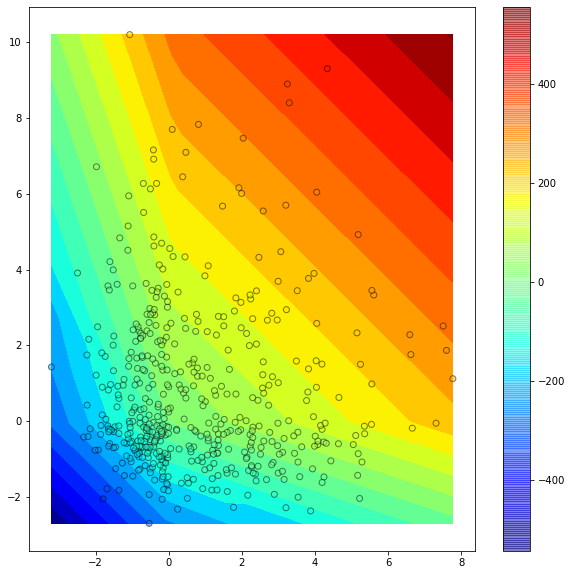

In [8]:
f, ax = plt.subplots(figsize=(10,10))
ax.contourf(g1,g2,y_pred.reshape(200,200), levels=25, cmap='jet', vmin=y_pred.min(), vmax=y_pred.max())
# plt.colorbar()
c = ax.scatter(X[:,0], X[:,1], c=y, cmap='jet', edgecolors='k', alpha=0.5, vmin=y_pred.min(), vmax=y_pred.max())
plt.colorbar(c,ax=ax)